### Imports

In [28]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# Computational packages
import numpy as np
import matplotlib.pyplot as plt
import torch
#import cv2 as cv

# General packages
import sys

# avoid adding multiple relave paths to sys.path
sys.path.append("../src") if "../src" not in sys.path else None 
from Models import SorscherRNN
from Experiment import Experiment
from methods import *
from datahandling import *
from stats import *
from astropy.convolution import Gaussian2DKernel, convolve

import umap
from sklearn.cluster import DBSCAN 
from sklearn.decomposition import PCA

import matplotlib.cm
import matplotlib.colors

import scipy.stats

ModuleNotFoundError: No module named 'spatial_maps'

## First we need some utilities for loading and running the model; load ratemaps and scores

In [30]:
def load_model(experiment):
    # Load a model attached to an experiment
    loc = experiment.paths
    # load weights
    checkpoint_filenames = filenames(loc['checkpoints'])
    # load model latest (wrt. #epochs trained)
    print(f"Loading model at epoch = {checkpoint_filenames[-1]}", loc['checkpoints'] / checkpoint_filenames[-1])
    checkpoint = torch.load(loc['checkpoints'] / checkpoint_filenames[-1])
    # instantiate trained model this time
    model = SorscherRNN(pc_ensembles, Ng=params['Ng'], Np=params['Np'])
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

def load_ratemaps(experiment):
    # load grid scores + ratemaps
    ratemaps = []
    kernel = Gaussian2DKernel(x_stddev=1)

    for env_i in range(len(experiment.environments)):
        with open(experiment.paths['ratemaps'] / f'env_{env_i}' / filenames(experiment.paths['ratemaps'] / f'env_{env_i}')[-1], "rb") as f:
            ratemaps.append(convolve(pickle.load(f), kernel.array[None]))
    ratemaps = np.concatenate(ratemaps)
    return ratemaps

def env_split(stats, n_envs, Ng=4096):
    # stack ratemaps by environment
    env_stat = []
    for env_i in range(n_envs):
        tmp = stats[Ng*env_i:Ng*(env_i+1)]
        env_stat.append(tmp)
    return np.array(env_stat)

In [31]:
def create_trajectories(dataset, environment_idx, num_trajectories=1500):
    """Generate trajectories to compute ratemaps with (scipy.stats.binned_statistics_2d)"""
    batch_velocities, batch_init_pc_positions, batch_positions = [], [], []
    for _ in range(num_trajectories):
        (velocities, init_pc_positions), _, positions, _ = dataset[environment_idx]
        batch_velocities.append(velocities)
        batch_init_pc_positions.append(init_pc_positions)
        batch_positions.append(positions)
    batch_inputs = [torch.stack(batch_velocities), torch.stack(batch_init_pc_positions)]
    batch_positions = torch.stack(batch_positions).detach().numpy()
    batch_velocities = torch.stack(batch_velocities).detach().numpy()
    return batch_inputs, batch_positions[:,1:], batch_velocities

def run_model(model, dataset, n_envs, samples = 1500, start = 0):
    # run model in inference mode on samples generated from dataset across environments.
    """
    model: SorscherRNN model
    dataset: dataset, passed to create_trajectories
    n_envs: number of environments
    samples: number of trajectories to run model on
    start: start index of returned timeseries; used to skip initial states
    """
    
    activities = []
    env_tags = []
    r = [] # positions
    v = [] # velocities

    for i in range(n_envs):
        batch_inputs, batch_pos, batch_v = create_trajectories(dataset, i, num_trajectories = samples)
        g = model.g(batch_inputs).detach().cpu().numpy()[:,start:]
        g = g.reshape(-1, g.shape[-1])
        activities.append(g)
        r.append(np.reshape(batch_pos[:,start:], (-1, batch_pos.shape[-1])))
        v.append(np.reshape(batch_v[:,start:], (-1, batch_v.shape[-1])))
        env_tags.append(np.ones(len(g))*i)

    activities = np.stack(activities, axis=0)
    r = np.stack(r, axis=0)
    v = np.stack(v,axis=0)
    return activities, env_tags, r, v

## And a convenient method for plotting 3D point clouds interactively

In [32]:
def plot_3d_proj(data, tags = None, cmap = "viridis", title = "", axes = None):
    if axes is None:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
    else:
        ax = axes
    ax.set_title(title)
    norm = matplotlib.colors.Normalize(np.amin(tags), np.amax(tags))
    col = matplotlib.cm.viridis(norm(tags))
    ax.scatter(xs=data[:,0], ys=data[:,1], zs=data[:,2], c = col, s = 15, alpha = 0.7, cmap = cmap)
    ax.axis("off")
    
    if axes is None:
        return fig

In [33]:
def pca_UMAP(states):
    """ Run PCA followed by UMAP on states; Similar to Gardner et al. (2022)
    
    states.shape = (Nsamples, Nfeatures)
    PCA down to 6 features/principal components 
    UMAP of PCA componenents to 3 features.
    
    Note: Gardner et al. use n_neighbors = 5000 (more than number of samples in our case...)
    """
    pca_fit = PCA(n_components = 6).fit(states)
    pca_result = pca_fit.transform(states)
    umap_fit = umap.UMAP(n_components = 3, min_dist = 0.8,  # Almost Gardner et al. params
                         n_neighbors = 1000, metric = "cosine", init = "spectral")
    umap_result = umap_fit.fit_transform(pca_result)
    return pca_result, umap_result

### We follow the procedure of Gardner et al.:
The basic steps are this:
- Make low-resolution ratemaps for all cells (15x15 bins)
- Compute an autocorrelogram for each cell
- Crop the autocorrelogram using an annulus mask
- Standardize each cropped autocorrelogram over space (subtract mean, divide by stddev)
- Stack standardized, cropped autocorrelograms into matrix of shape (Ncells, nbins)
- Compute 2D UMAP of this matrix
- Perform clustering using DBSCAN to identify clusters.
- The clusters should identify cells with similar autocorrelograms (similar grid orientation + spacing).


## Define some methods for creating lower-res ratemaps and doing autocorrelations.

In [34]:
def autocorr(ratemaps, **kwargs):
    # compute autocorrelation of ratemap array, of shape (n_env, n_cells, px, py)
    img_size = (ratemaps.shape[-1]*2 - 1)
    corrs = np.zeros((ratemaps.shape[0], ratemaps.shape[1], img_size, img_size))
    
    for i in range(ratemaps.shape[0]):
        for j in range(ratemaps.shape[1]):
            corrs[i,j] = scipy.signal.correlate(ratemaps[i,j], ratemaps[i,j], **kwargs)
    return corrs

def annulus_mask(dims, inner_radius, outer_radius):
    center_x = int(dims[0]/2)
    center_y = int(dims[1]/2)
    
    x, y = np.ogrid[0:dims[0], 0:dims[1]]

    outer_mask = ((x - center_x) ** 2 + (y - center_y)** 2) <= (outer_radius**2)
    inner_mask = (x - center_x)**2 + (y-center_y)**2 >= (inner_radius**2)
    # larger than inner, smaller than outer is False
    return outer_mask*inner_mask

def create_ratemaps(g, r, res):
    return scipy.stats.binned_statistic_2d(r[:,0], r[:,1], g.T, bins=res)[0]


In [35]:
def standardized_annuli(autocorr, mask):
    """ Crop autocorrelation ratemap using annulus mask and z-standardize.
    
    autocorr: autocorrelation ratemap
    mask: annulus mask
    """
    flat_mask = np.ravel(mask) # 1D annulus mask

    result = [] # save standardized annuli
    std_mask = [] # track cells with zero stddev on annulus

    for i in range(len(autocorr)):
        corr_annulus = np.zeros((autocorr.shape[1], np.sum(flat_mask)))
        for j in range(autocorr.shape[1]): # autocorr.shape[1] is cell dimension
            corr_annulus[j] = np.ravel(autocorr[i,j])[flat_mask]

        # z standardization
        annulus_std = np.std(corr_annulus, axis = -1) # std over space
        std_mask.append(annulus_std != 0) # track cells with zero variance
        nonzero = corr_annulus[annulus_std != 0] # remove zero-variance cells from result
        annulus_mean = np.mean(nonzero, axis = -1, keepdims = True)
        standardized = (nonzero - annulus_mean)/np.std(nonzero, axis = -1, keepdims = True)
        result.append(standardized)
    return result, std_mask

In [36]:
def cluster_modules(autocorr_annuli):
    """ Grid module identification, following Gardner et al.
    
    Procedure is to convert z-standardized annuli of low-res. ratemaps to a matrix
    of shape (n_cells, n_bins), then do a 2D UMAP of this matrix.
    
    Clustering is then performed on the low-dimensional representation.
    Clustering uses DBSCAN.
    returns 
    """

    low_dim = []
    cluster_labels = []
    for i in range(len(autocorr_annuli)):
        transform = umap.UMAP(metric = "manhattan", n_neighbors = 5, min_dist = 0.05, init = "spectral")
        low_dim.append(transform.fit_transform(autocorr_annuli[i]))
        clustering = DBSCAN(min_samples = 30, eps = 0.5).fit(low_dim[-1])
        cluster_labels.append(clustering.labels_)
    return low_dim, cluster_labels

### We can then apply our machinery to a trained model

In [37]:
# load a model to create low res ratemaps
base_path = "/home/users/vemundss/"
experiment = load_experiment(base_path, "gg-3ME")
model = load_model(experiment)
ratemaps = load_ratemaps(experiment)  # load HD ratemaps

# where to save indices of interesting cells
save_loc = "/home/users/markusbp/data/emergent-grid-cells/"

NameError: name 'load_experiment' is not defined

In [38]:
# reshape arrays by environment
scores = env_split(scores, n_envs = len(experiment.environments))
ratemaps = env_split(ratemaps, n_envs = len(experiment.environments))

NameError: name 'scores' is not defined

In [39]:
dataset = Dataset(agents = experiment.agents, pc_ensembles = experiment.pc_ensembles, num_samples = 1500, **experiment.params)

NameError: name 'experiment' is not defined

In [43]:
n = 5000
acts, tags, r, v = run_model(model, dataset, len(experiment.environments), samples = n, start = 10)

NameError: name 'model' is not defined

In [41]:
small_maps = []
for i in range(len(ratemaps)):
    small_maps.append(create_ratemaps(acts[i], r[i], res = [15, 15])) 
small_maps = np.array(small_maps)
small_maps.shape

NameError: name 'environments' is not defined

In [42]:
corrs = autocorr(small_maps)

outer = int(corrs.shape[-1]/2*0.9) 
inner = int(corrs.shape[-1]/2*0.15)
mask = annulus_mask(corrs.shape[-2:], inner, outer)

# show a few examples; appears to exclude center peak as it should

fig, ax = plt.subplots(4, 5, figsize = [5, 5])
for i in range(20):
    ind = np.random.randint(corrs.shape[1])
    img = np.copy(corrs[0,ind])
    img[~mask] = np.nan
    row = i % 4
    col = i % 5
    ax[row, col].imshow(img)



AttributeError: 'list' object has no attribute 'shape'

In [18]:
result, std_mask = standardized_annuli(corrs, mask)

In [19]:
low_dims, cluster_labels = cluster_modules(result)

In [21]:
# And fit PCA + UMAP  to each cluster to see if they are actually toroidal
pca_fits = []
umap_fits = []
labels = []

# ratemaps.shape = (nenvs, ng, nx, ny) --> nenvs, nx*ny, ng
g = ratemaps.reshape((*ratemaps.shape[:2], -1))
g = np.transpose(g, (0, 2, 1))

for i in range(len(experiment.environments)):
    env_pca = []
    env_umap = []
    env_labels = []

    for ind in np.unique(cluster_labels[i]):
        selected = cluster_labels[i] == ind
        # only do pca + umap if cluster contains more than 6 units. 
        if selected.sum() > 6:
            pca_fit, u = pca_UMAP(g[i][:,std_mask[i]][:,selected])
            env_pca.append(pca_fit)
            env_umap.append(u)
            env_labels.append(ind)
            
    pca_fits.append(env_pca)
    umap_fits.append(env_umap)
    labels.append(env_labels)

/tmp/ipykernel_1690602/1946048407.py:3: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



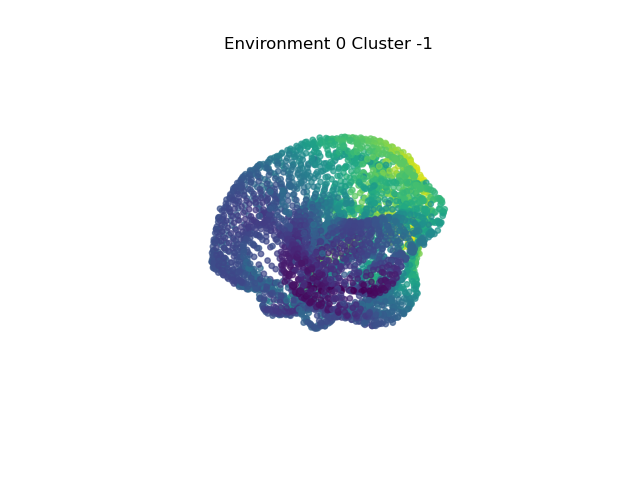

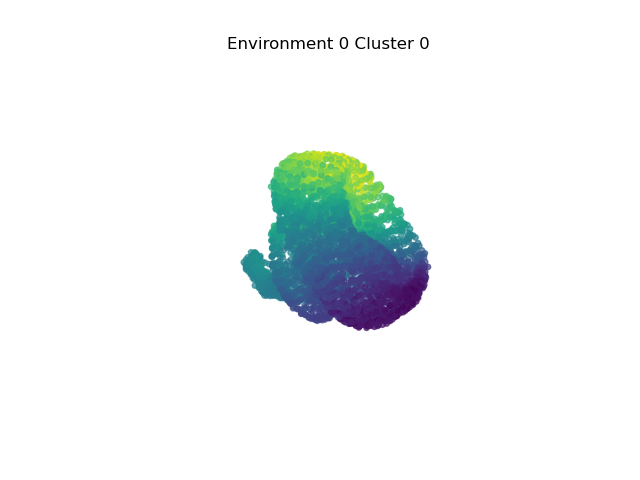

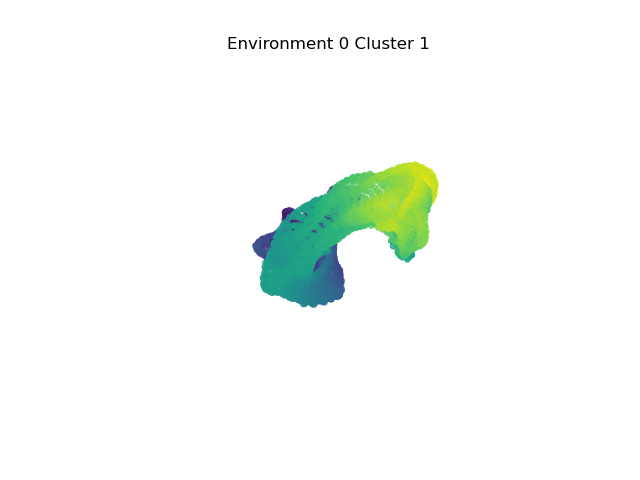

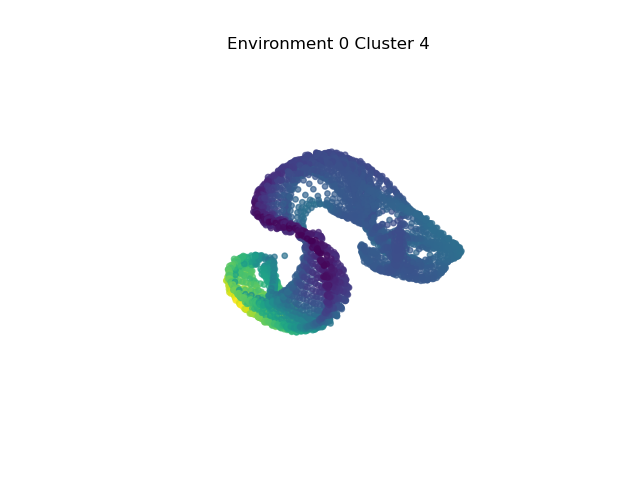

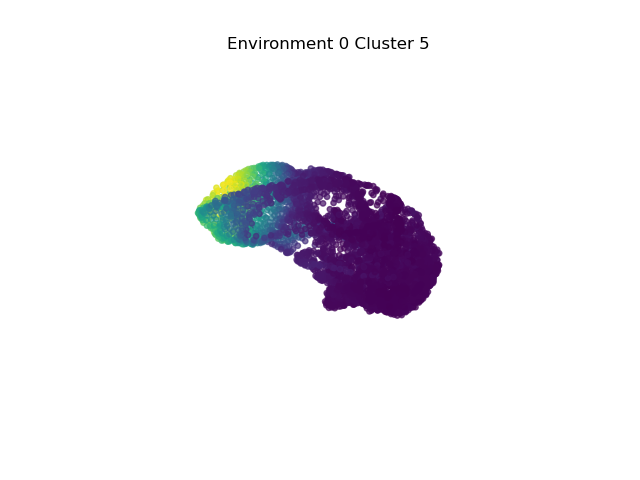

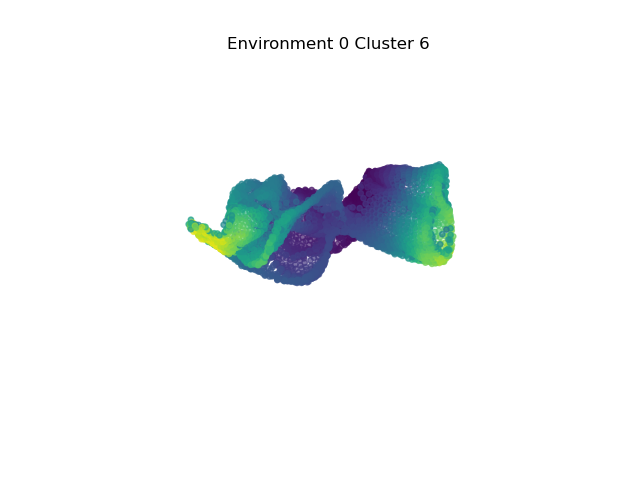

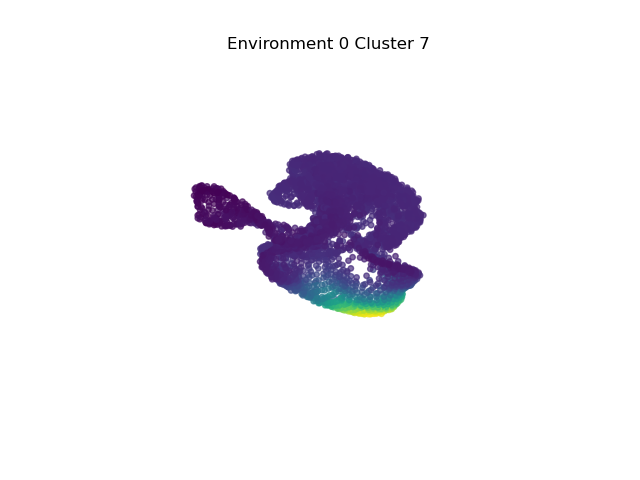

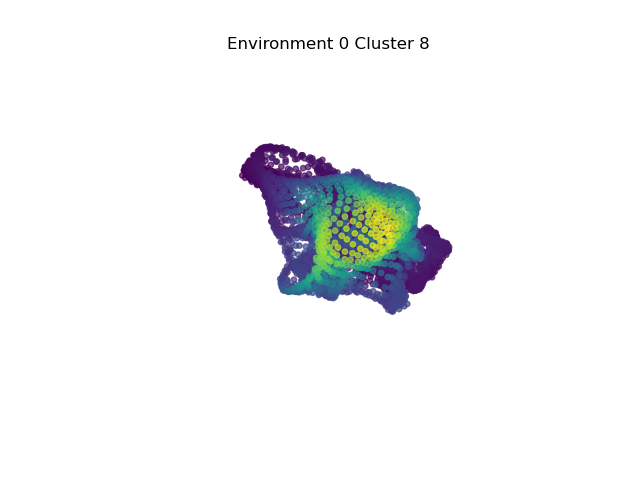

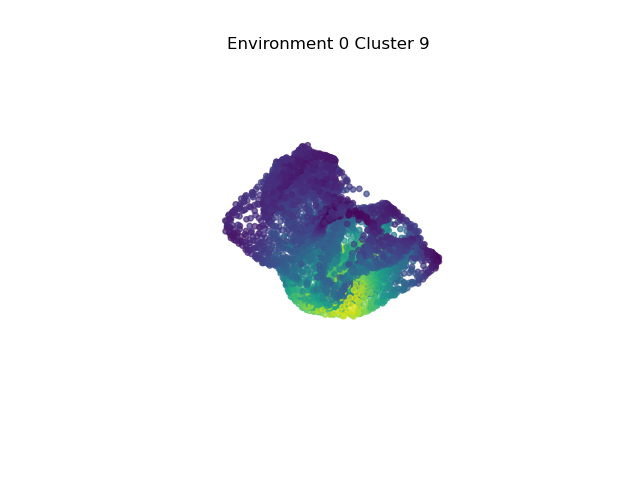

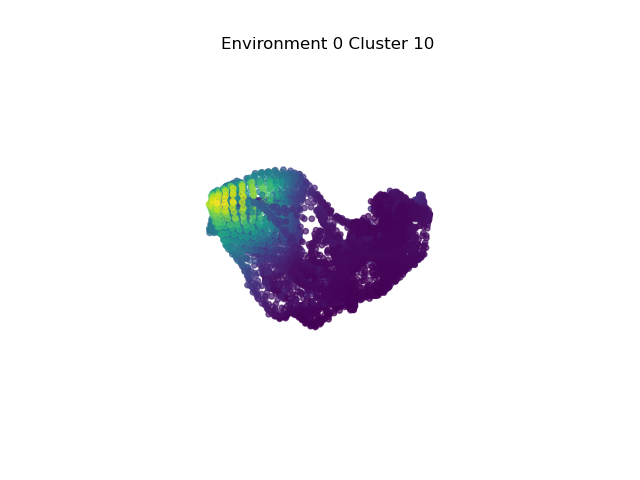

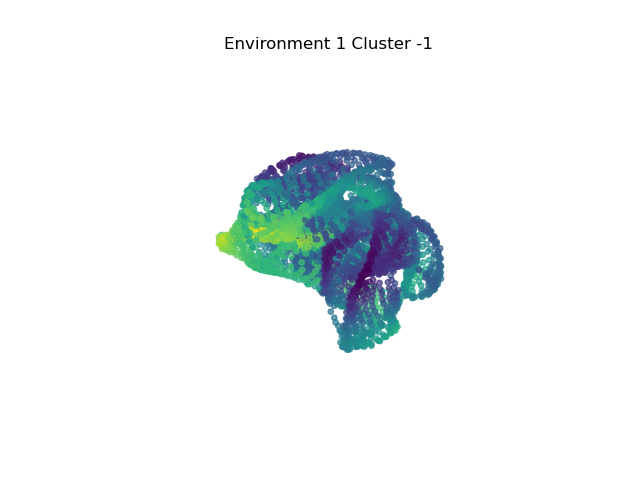

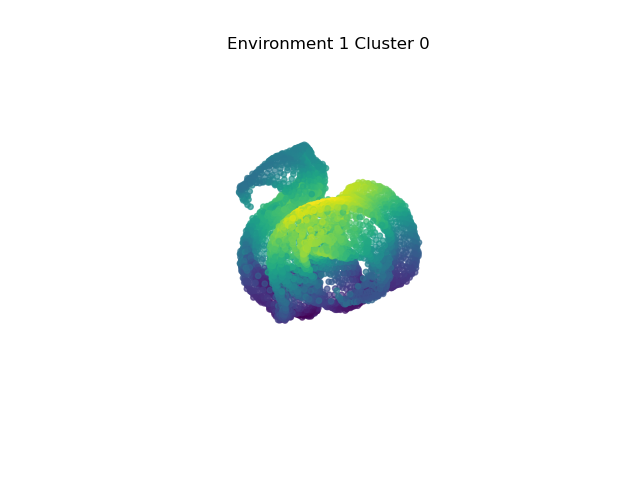

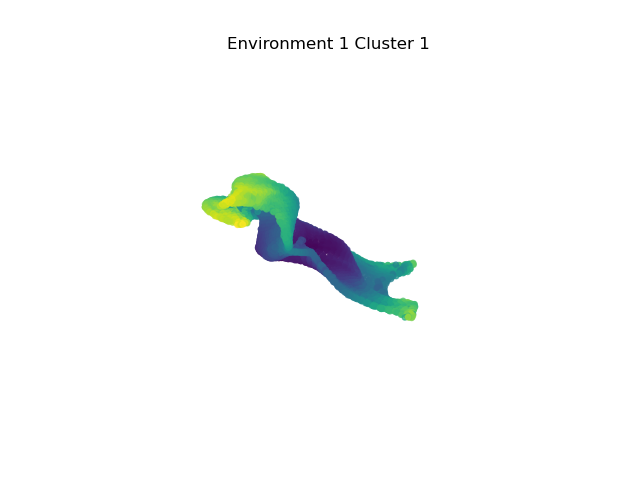

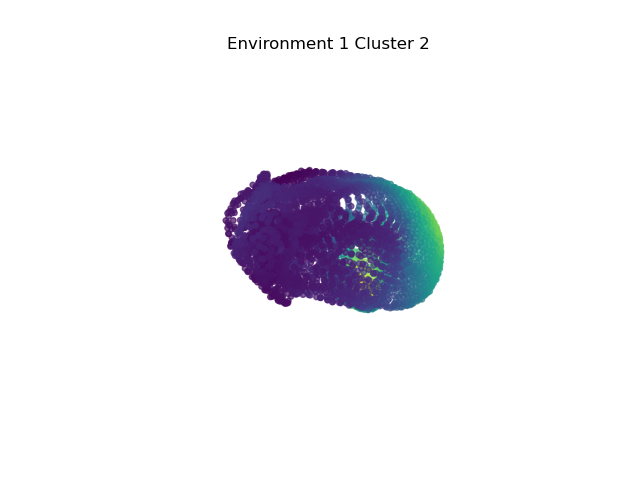

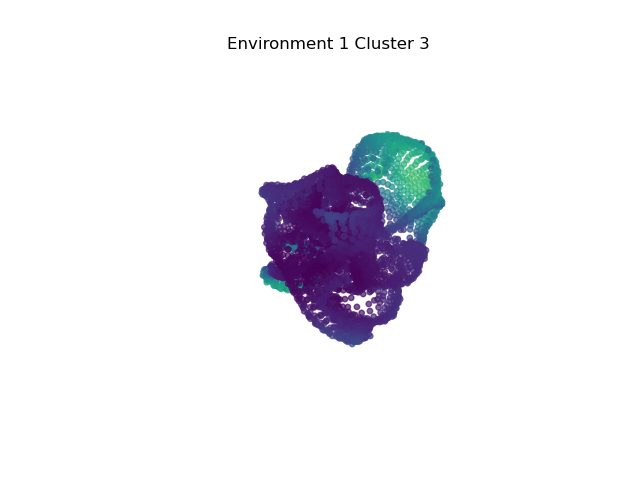

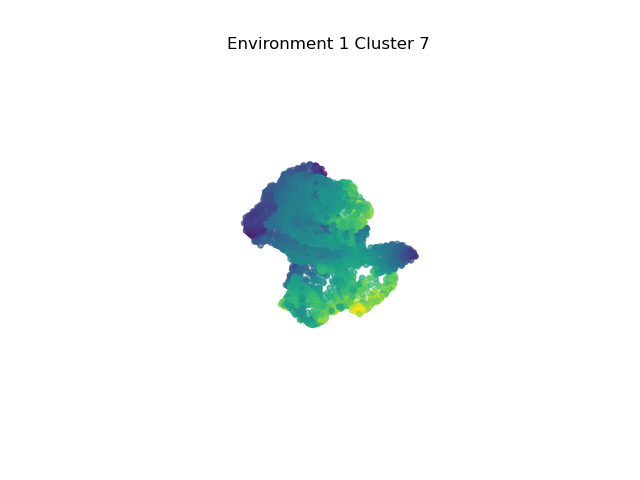

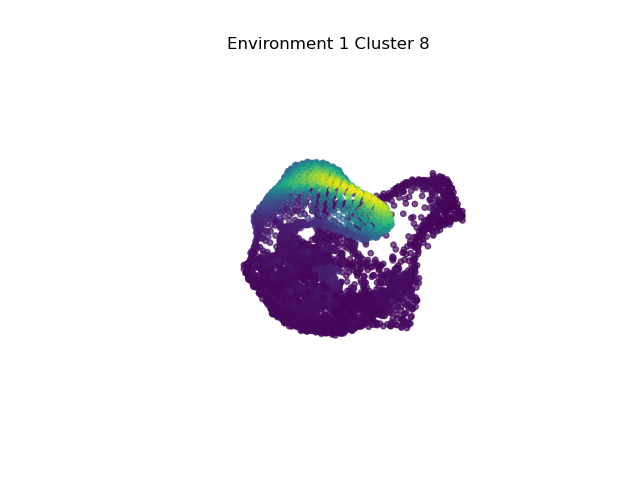

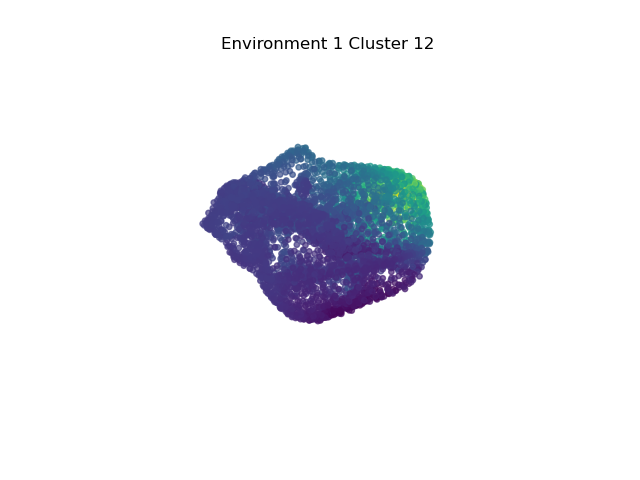

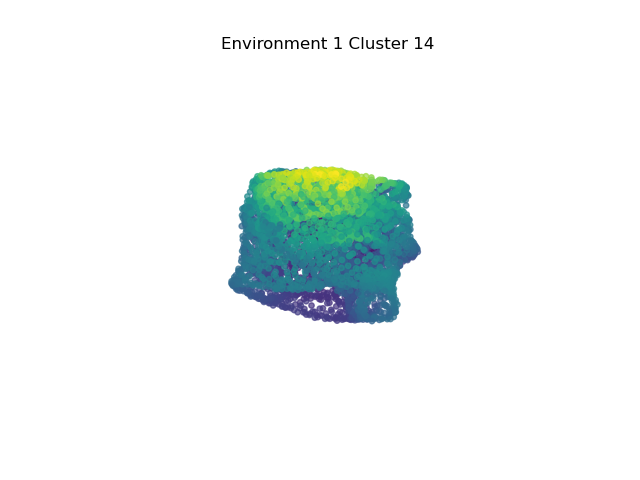

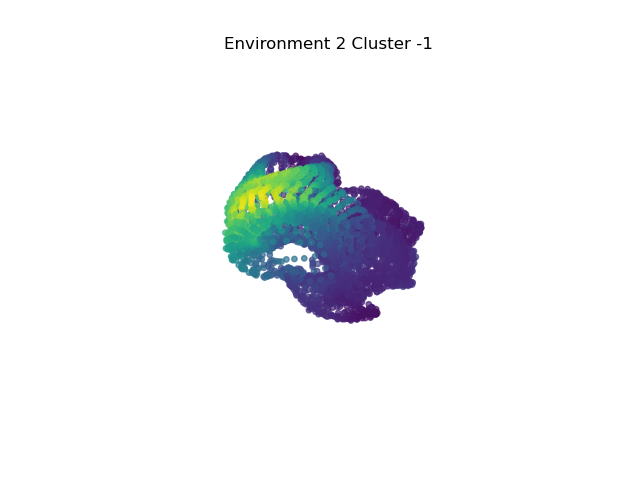

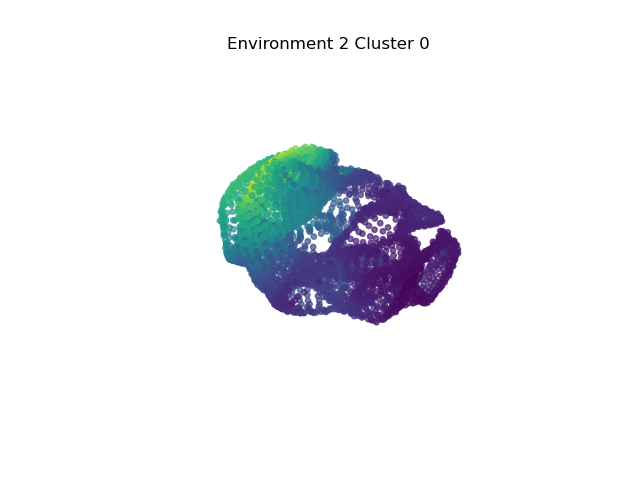

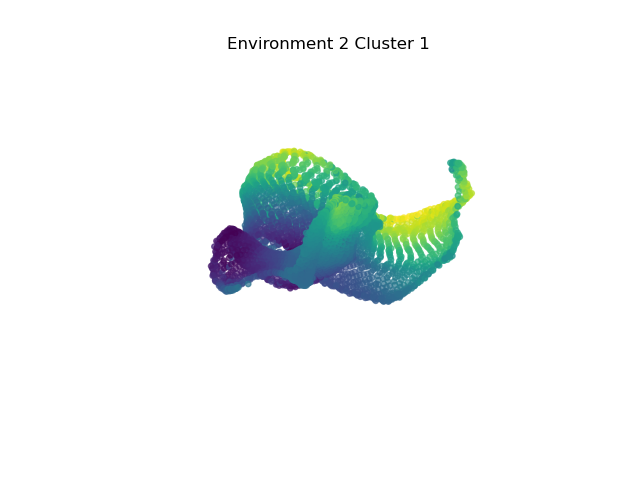

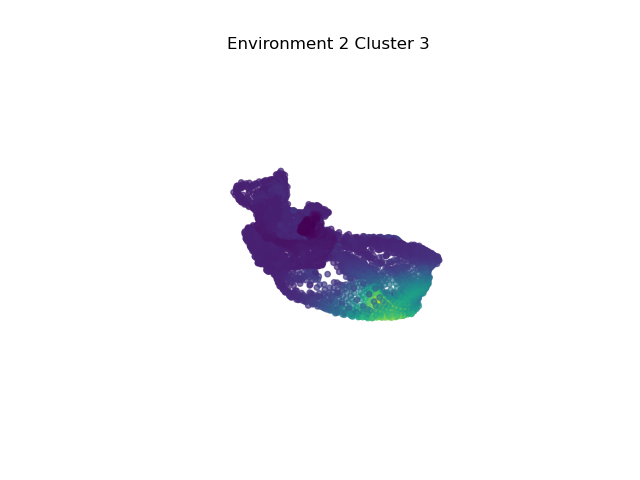

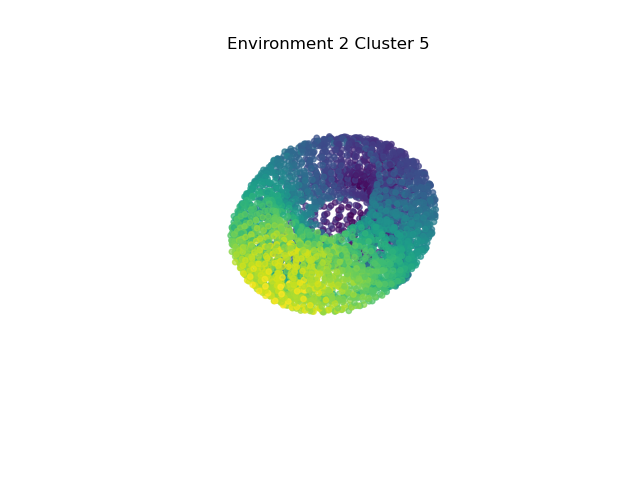

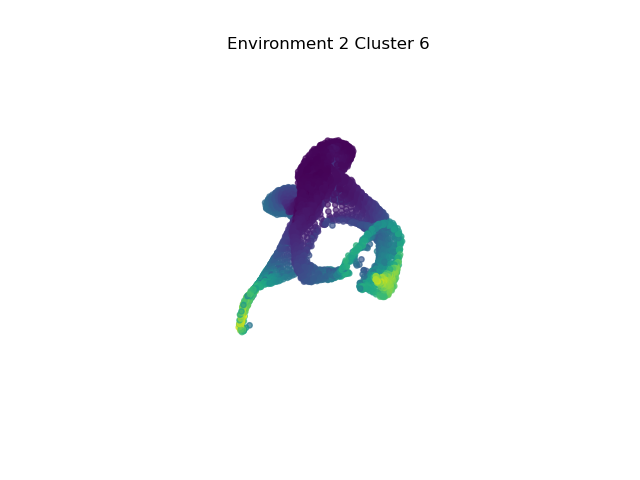

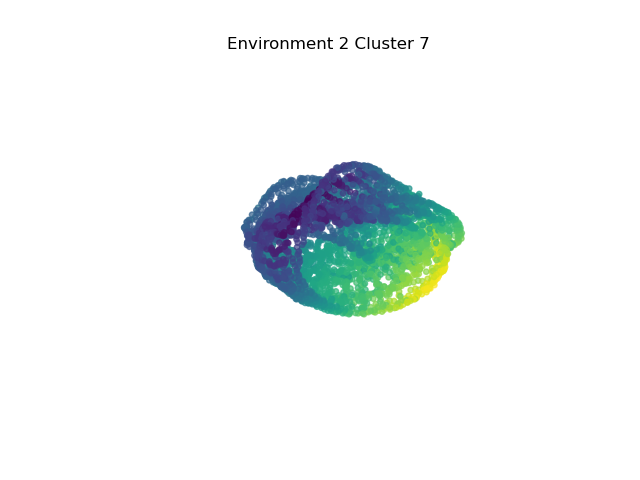

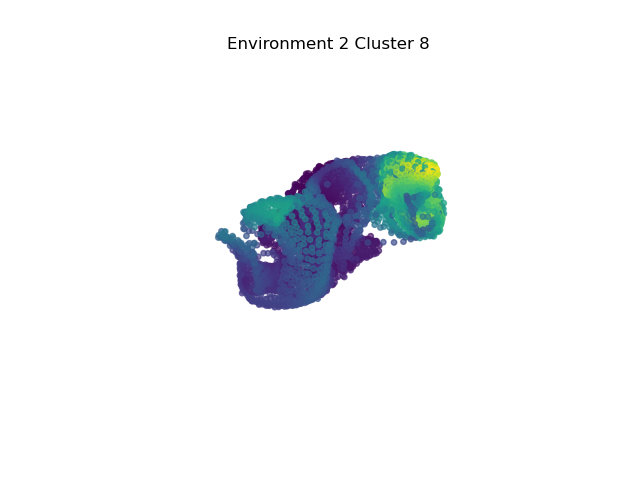

In [22]:
for i in range(len(experiment.environments)):
    for u, pc, label in zip(umap_fits[i], pca_fits[i], labels[i]):
        fig = plot_3d_proj(u, pc[:,0], title = f"Environment {i} Cluster {label}")        
    

In [26]:
interesting_clusters = [[0], [5], [5] ] # identify interesting clusters in each env

## Finally, we save the different indices required to select the cells that set up the above tori

In [27]:
cell_inds = []
descriptions = []
for i, ind in enumerate(interesting_clusters):
    cluster_inds = interesting_clusters[i]
    for j in cluster_inds:
        selected = cluster_labels[i] == j
        mask = std_mask[i]
        # pick out indices that have nonzero stddev AND belong to an interesting cluster
        cell_inds.append(np.nonzero(std_mask[i])[0][selected])
        descriptions.append(f"C{j}_from_env_{i}")
        

In [28]:
# And save for posterity
x = {descriptions[i]: cell_inds[i] for i in range(len(descriptions))}
np.savez(f"{save_loc}module_indices", **x)